# Novelty detection in Electroencephalography (EEG) using a Two-Layer Convolutional Neural Network 

## Contens:
* [Loading packages](#Loading-packages)
* [Loading data](#Loading-data)
* [Spectorgram figure function](#Spectorgram-figure-function)
* [Training Neural Network](#Training-Neural-Network)
* [Testing_Neural_Network](#Testing_Neural_Network)
* [PCA](#PCA)

# Loading packages

Packages used in the notebook are imported

In [2]:
import os
import sys
#path1 = 'C:/Users/Emilie/Documents/GitHub/DeepLearningProject'
path1 = '/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject'
sys.path.insert(0,os.path.abspath(path1))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

import mne

import scipy
from scipy import signal
from scipy.linalg import svd

from IPython.display import clear_output

from skimage.io import imread
from skimage.transform import resize
import torch
import data_utils


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, max_pool2d, avg_pool2d
from torch import sigmoid

from sklearn.metrics import confusion_matrix
# PCA and outlier detection related imports:
from sklearn.decomposition import PCA

from matplotlib.pyplot import (figure, imshow, bar, title, xticks, yticks, cm, subplot, show, savefig) 
from scipy.io import loadmat
from toolbox_02450 import gausKernelDensity
from sklearn.neighbors import NearestNeighbors
from scipy import stats

# Loading data

The raw EEG data from September 1st are imported and are filtered, trasnformed and noise are added. In this project it is only one sensor location which will be used, P3. 
Next, the filtered and transformed data is split into train, test and validation set. 

In [ ]:
# Loading EEG files from folder 
*edf from folders 

## Path to the EEG files
#path = 'E:/DeepLearningEEG/dataEEG/Original participant EEGs/1SeptLille'
path = '/Users/ibenfjordkjaersgaard/Documents/Uni/Kandidat/Semester1/DeepLearning/project/dataEEG/Original participant EEGs/1Sept'
os.chdir(path)
window_size = 60 
selection = ['P3'] 

j=0
for filename in os.listdir('.'):
    if filename.endswith('.edf'):
        raw = mne.io.read_raw_edf(filename, preload = True)
        picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads', selection=selection)

        # Filter data with low and high frequancy 
        raw.filter(l_freq=0.5, h_freq=40)
        freq = raw.info['sfreq']
        num_samples = raw.n_times
        
        # Splitting data according to window size 
        lower_bound = list(range(0, int(num_samples/freq)-window_size, window_size-int(window_size/2)))
        upper_bound = list(range(window_size, int(num_samples/freq), window_size-int(window_size/2)))
        i = 0
        
        # Add noise to pictures with index in noisePicture 
        noisePicture = random.sample(range(2032), 2032//2)

        for low, up in zip(lower_bound,upper_bound):

            raw_subset = raw.copy()
            raw_subset.crop(tmin = low, tmax = up).load_data()
            raw_subset.filter(l_freq=0.5, h_freq=40)
            data = raw_subset.get_data(picks=picks)[0]

            # if the i'te data is having added noise 
            if i in noisePicture:  
                cov = mne.make_ad_hoc_cov(raw_subset.info)
                cov['data']*= 1000**2 
                rng = np.random.RandomState(10) 
                mne.simulation.add_noise(raw_subset, cov)
                raw_subset.filter(l_freq=0.5, h_freq=40)
                data = raw_subset.get_data(picks=picks)[0]

                if j == 0:
                    y = [1] #finding the widows which have added noise 
                else:
                    y = np.append(y,[1], axis=0)
            else:
                data = data
                if j == 0:
                    y = [0]
                else:
                    y = np.append(y,[0], axis=0)
                    
            # Save spectogram data         
            ps, _, _, _ =plt.specgram(data, Fs = freq)
            s = ps.shape
            ps = ps.reshape(1,s[0], s[1], 1)

            # Append filtered data and spectrogram data
            if j == 0:
                imgs = ps
                dataTid = data
            else:
                imgs = c = np.concatenate((imgs,ps), axis=0)
                dataTid  = np.append(dataTid,data, axis=0)

            if i == 100: # max size manually set to 101 pics per file
                break
            i+=1
            
        j+=1

# Save data on specific shape        
dataTid=dataTid.reshape(imgs.shape[0],-1)
# Save logarithmic data.
data_log = 10 *np.log10(dataTid+1)
# Save vector which indicates if noise have been added to the picture or not  
yTranspose = np.transpose(y)

In [ ]:
# Loading EEG data inTest, Train and Valdiation set 

def load_data():
    ## NB: Split in train and validation 
    mask = np.zeros(len(dataTid),dtype=bool)
    testIdx = random.sample(range(imgs.shape[0]), int(np.ceil(0.4*imgs.shape[0])))
    mask[testIdx]=True

    print(dataTid.shape)
    valIdx = testIdx[:len(testIdx)//2]
    testIdx=testIdx[len(testIdx)//2:]


    dataTest = dataTid[testIdx,]
    dataTrain =dataTid[~mask]
    dataVal = dataTid[valIdx,]


    dataTrain=dataTrain[:,:7611]
    dataTest=dataTest[:,:7611]
    dataVal=dataVal[:,:7611]

    dataTest = dataTest.reshape(-1,1, 129,59)
    dataTestTid = torch.from_numpy(dataTid[:,:7611].reshape(-1,1, 129,59))

    nchannels, rows, cols=1,129,59

    X_train = dataTrain.astype('float32')
    X_train = X_train.reshape((-1, nchannels, rows, cols))

    X_test = dataTest.astype('float32')
    X_test = X_test.reshape((-1, nchannels, rows, cols))

    X_valid = dataVal.astype('float32')
    X_valid = X_valid.reshape((-1, nchannels, rows, cols))

    y_train = yTranspose[~mask].astype('int32')
    y_test = yTranspose[testIdx].astype('int32')
    y_valid = yTranspose[valIdx].astype('int32')

    
    print("Train samples:", X_train.shape)
    print("Validation samples:", X_valid.shape)
    print("Test samples:", X_test.shape)

    return dict(
        X_train=np.asarray(X_train, dtype='float32'),
        y_train=y_train.astype('int32'),
        X_valid=np.asarray(X_valid, dtype='float32'),
        y_valid=y_valid.astype('int32'),
        X_test=np.asarray(X_test, dtype='float32'),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

# Spectorgram figure function 

In [242]:
# Function which plot spectogram with the same scale. 
def plot_specgram(data, title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    pxx,  freqt, t, cax = plt.specgram(data, Fs=freq,cmap= 'viridis',  vmin = -170, vmax = -40 )
    fig.colorbar(cax1).set_label('Intensity [dB]')

In [ ]:
plot_specgram(data_log[5],title='', 
              x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))
savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/sepctogram_normal.png')


plot_specgram(data_log[0],title='', 
              x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))
savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/sepctogram_added_artificial_noise.png')


# Training Neural Network

First is the two-layer convolutional neural netrowk defined. Next is the neural network traoned on the prepared data.

In [258]:
# hyperameters of the model
num_classes = 2
channels = data['X_train'].shape[1]
height = data['X_train'].shape[2]
width = data['X_train'].shape[3]
num_filters_conv1 = 25
kernel_size_conv1 = 5 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
num_l1 = 50
padding_conv1 = 2

num_filters_conv2 = 9
kernel_size_conv2 = 3 # [height, width]
stride_conv2 = 1 # [stride_height, stride_width]
padding_conv2 = 1


   
def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv2 + 2 * padding_conv2) / stride_conv2 + 1)

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #out_dim = (input_dim - filter_dim +2*padding) / stride + 1
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1)
        
        self.conv_2 = Conv2d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2,
                             padding=padding_conv2)

        
        self.conv_out_height = compute_conv_dim(height)
        self.conv_out_width = compute_conv_dim(width)
        
         # Batchnorms for conv
        self.batchnorm_conv1 = nn.BatchNorm2d(25)#den kom selv med det "rigtige" i fejlen#conv_out_channels 
       
        # add dropout to network
       # self.dropout = Dropout2d(p=0.05)
        self.l1_in_features = num_filters_conv1 * self.conv_out_height * self.conv_out_width
        self.l2_in_features = num_filters_conv2 * self.conv_out_height * self.conv_out_width
        #self.l1_in_features = channels * height * width
        #self.l3_in_features = int((dim_size - 5 + 2 * 0) / 5 + 1)
        self.pool_h = int((height - 2 + 2 * 0) / 2+ 1)
        self.pool_w = int((width - 2+ 2 * 0) / 2+ 1)
        self.pool_feat = num_filters_conv2 * self.pool_h * self.pool_w
        
        self.l_1 = Linear(in_features=self.pool_feat, 
                          out_features=num_l1,
                          bias=True)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
        
        
        
    def forward(self, x): # x.size() = [batch, channel, height, width]
        features =[]
        x = self.conv_1(x)
        x = relu(x)
        x = avg_pool2d(x, kernel_size=2, stride=2, padding=0) 
        x = self.batchnorm_conv1(x)
        
        
        x = self.conv_2(x)
        x = relu(x)

        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        x = x.view(-1, self.pool_feat)
        features.append(x)
        features_cat=torch.cat(features, dim=1)

        x = self.l_1(features_cat)
        feature_vec = relu(x)
       # x = self.dropout(feature_vec)
        x = self.l_out(x)
        
        return feature_vec, sigmoid(x)#, softmax(x, dim=1) 


net = Net()
print(net)

Net(
  (conv_1): Conv2d(1, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_2): Conv2d(25, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm_conv1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_1): Linear(in_features=16704, out_features=50, bias=True)
  (l_out): Linear(in_features=50, out_features=2, bias=False)
)


In [259]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# we could have done this ourselves,
# but we should be aware of sklearn and it's tools
from sklearn.metrics import accuracy_score

batch_size = 100
num_epochs = 50
num_samples_train = data['X_train'].shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = data['X_valid'].shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train() # forward
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(data['X_train'][slce]))
        feature_vec, output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(data['y_train'][slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(data['X_train'][slce]))
        
        feature_vec,output = net(x_batch)
        preds = torch.max(output, 1)[1]
        #print(preds)
        
        train_targs += list(data['y_train'][slce])
        train_preds += list(preds.data.numpy())
        print(preds.data.numpy())
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(data['X_valid'][slce]))
        
        feature_vec,output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(data['y_valid'][slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    #if epoch % 10 == 0:
    print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

### Evaluate test set
x_batch = Variable(torch.from_numpy(data['X_test']))
feature_vec, output = net(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(data['y_test']), list(preds.data.numpy()))))

In [ ]:

plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/test_uden_dropout.png')
plt.show()
#Test set Acc:  0.987212

y_true = data['y_test']
y_pred = preds
confusion_matrix(y_true,y_pred)

In [263]:
torch.save(net.state_dict(), 'our_pretrained_spec.pt')

In [264]:
new_net = Net()

In [265]:
new_net.load_state_dict(torch.load('our_pretrained_spec.pt'))

<All keys matched successfully>

# Testing Neural Network

The raw EEG data from September 5st are imported and are filtered and trasnformed. In this project it is only one sensor location which will be used, P3. 
Next, the filtered and transformed data is shaped in the right form using the function load_data_test. 

In [266]:
new_net.eval()

Net(
  (conv_1): Conv2d(1, 25, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_2): Conv2d(25, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm_conv1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_1): Linear(in_features=16704, out_features=50, bias=True)
  (l_out): Linear(in_features=50, out_features=2, bias=False)
)

In [ ]:
## IMPORTANT: Test.edf cannot be from 1Sept folder!!!!

## Path to the EEG files
#path = 'E:/DeepLearningEEG/dataEEG/Original participant EEGs/1SeptLille'
path = '/Users/ibenfjordkjaersgaard/Documents/Uni/Kandidat/Semester1/DeepLearning/project/dataEEG/Original participant EEGs/5Sept'
#os.environ['PATH'] += ':'+path
os.chdir(path)
window_size = 60 
selection = ['P3']

j=0
for filename in os.listdir('.'):
    if filename.endswith('.edf'):
        raw = mne.io.read_raw_edf(filename, preload = True)
        picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,
                       stim=False, exclude='bads', selection=selection)

        # Filter data
        raw.filter(l_freq=0.5, h_freq=40)
        freq = raw.info['sfreq']
        num_samples = raw.n_times
        lower_bound = list(range(0, int(num_samples/freq)-window_size, window_size-int(window_size/2)))
        upper_bound = list(range(window_size, int(num_samples/freq), window_size-int(window_size/2)))
        i = 0
        
        noisePicture = []

        for low, up in zip(lower_bound,upper_bound):

            raw_subset = raw.copy()
            raw_subset.crop(tmin = low, tmax = up).load_data()
            raw_subset.filter(l_freq=0.5, h_freq=40)
            data = raw_subset.get_data(picks=picks)[0]

            ps, _, _, _ =plt.specgram(data, Fs = freq)
            s = ps.shape
            ps = ps.reshape(1,s[0], s[1], 1)


            if j == 0:
                imgs_test = ps
                dataTid_test = data
            else:
                imgs_test = c = np.concatenate((imgs_test,ps), axis=0)
                dataTid_test  = np.append(dataTid_test,data, axis=0)

            if i == 100: # max size manually set to 101 pics per file
                break
            i+=1
            
        j+=1

# Save data on specific shape        
dataTid_test=dataTid_test.reshape(imgs_test.shape[0],-1)
# Save logarithmic data.
data_log_test = 10 *np.log10(dataTid_test+1)        

In [269]:
def load_data_test():
    ## NB: Split in train and validation 

    dataTest=dataTid_test[:,:7611]

    dataTest = dataTest.reshape(-1,1, 129,59)
    dataTestTid = torch.from_numpy(dataTid[:,:7611].reshape(-1,1, 129,59))

    nchannels, rows, cols=1,129,59

    X_test = dataTest.astype('float32')
    X_test = X_test.reshape((-1, nchannels, rows, cols))

    print("Test samples:", X_test.shape)

    return np.asarray(X_test, dtype='float32')

data_use_test = load_data_test()

Test samples: (1017, 1, 129, 59)


In [270]:
noise_dataTid_test = torch.FloatTensor(data_use_test)
with torch.no_grad(): # cannot make a numpy if it requires grad
    feature_vector_new_net, output_new_net = new_net(noise_dataTid_test)
    
imgs_feature_vector = feature_vector_new_net

# PCA 

In [ ]:

## PCA Func: 
#n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset
# project from 64 to 2 dimensions
specto_pca = PCA(n_components=0.99)
specto_pca.fit(imgs_feature_vector)
PCAdata = specto_pca.fit_transform(imgs_feature_vector)


In [ ]:
plt.scatter(PCAdata[:, 0], PCAdata[:, 1])
plt.xlim(1.2*PCAdata[:,0].min(),1.2*PCAdata[:,0].max())
plt.ylim(1.2*PCAdata[:,1].min(),1.2*PCAdata[:,1].max())
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

torch.Size([1017, 50])
(1017, 50)


(1017, 1)

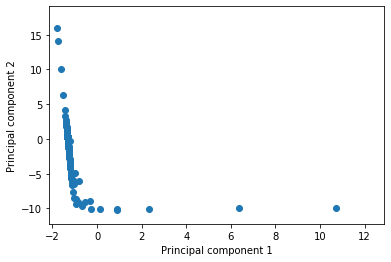

In [273]:
# TROR IKKE DENNE SKAL MED, DET ER DER HVOR VI FJERNE DE SIDSTE 
pca = PCA()  
projected = pca.fit_transform(imgs_feature_vector)
print(imgs_feature_vector.data.shape)
print(projected.shape)

plt.scatter(PCAdata[:, 0], PCAdata[:, 1])
plt.xlim(1.2*PCAdata[:,0].min(),1.2*PCAdata[PCAdata[:,0].argsort()[-6],0])
plt.ylim(1.2*PCAdata[:,1].min(),1.2*PCAdata[:,1].max())
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

PCAdata.shape

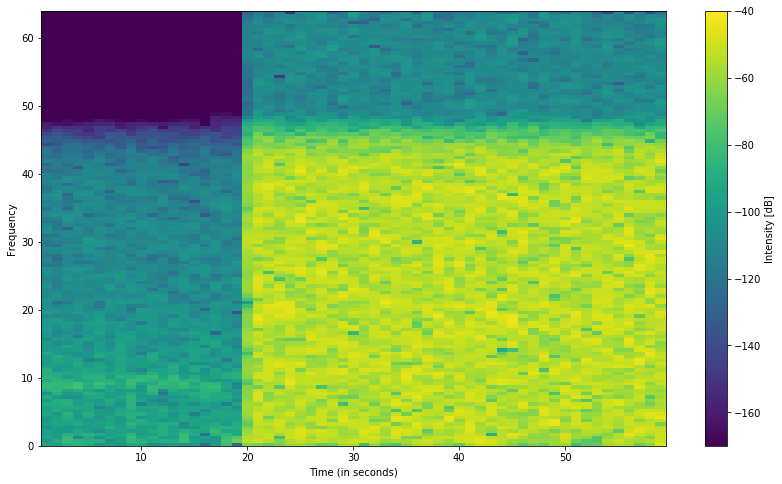

In [278]:
# Plot the outlierstest
ii = PCAdata[:,0].argsort()[-3]#projected[:,0].argmax()
a = data_log_test[ii,:]
plot_specgram(a,title='', x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))

#savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/sepctogram_added_artificial_noise.png')

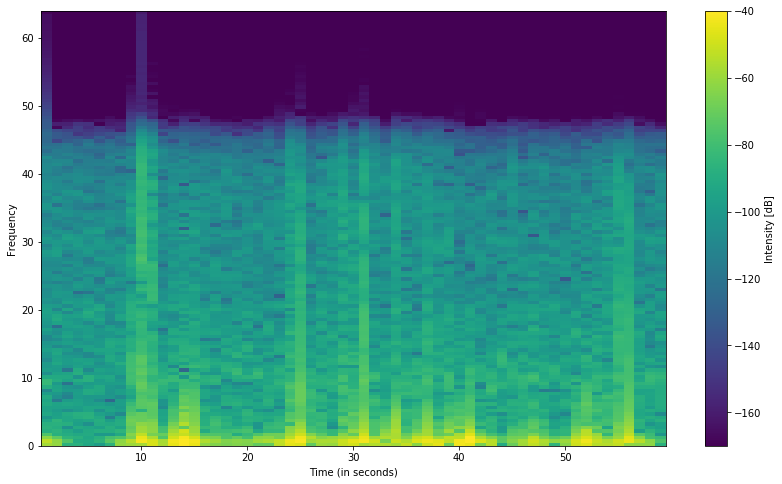

In [279]:
ii = PCAdata[:,0].argsort()[0]#projected[:,0].argmax()
a = data_log_test[ii,:]
plot_specgram(a,title='', x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))

#savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/sepctogram_added_artificial_noise.png')


In [287]:
N1,M1 = 59,129
imgslog = 10*np.log10(imgs_feature_vector)

# Let PCAdata be the X matrix for the outlier detection
X = np.matrix(PCAdata)


### Distance to 5'th nearest neighbor outlier score
K = 5

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(X)

# Outlier score
score = D[:,K-1]
# Sort the scores
i = score.argsort()
score = score[i[::-1]]

# Plot k-neighbor estimate of outlier score (distances)
figure(7)
#bar(range(20),score[:20])
#title('5th neighbor distance: Outlier score')
# Plot possible outliers

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

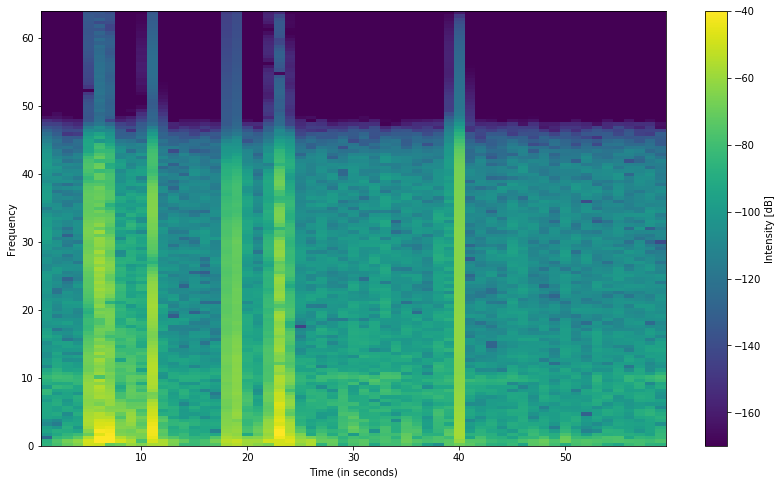

In [300]:
plot_specgram(data_log_test[i[-7],:],title='', 
              x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))

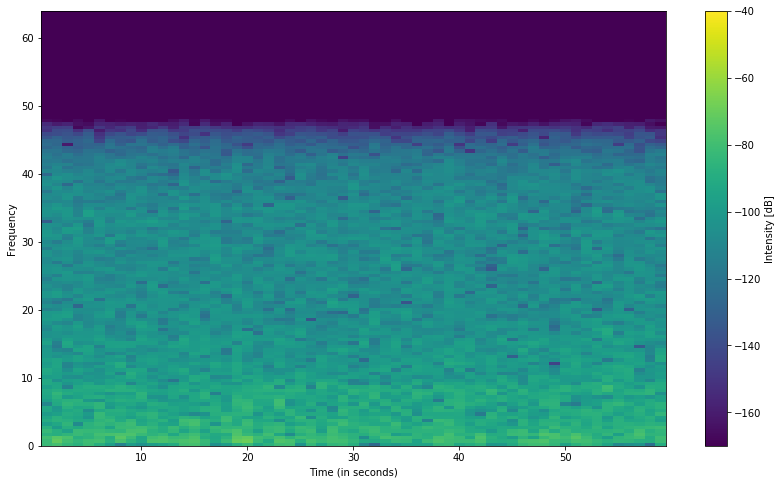

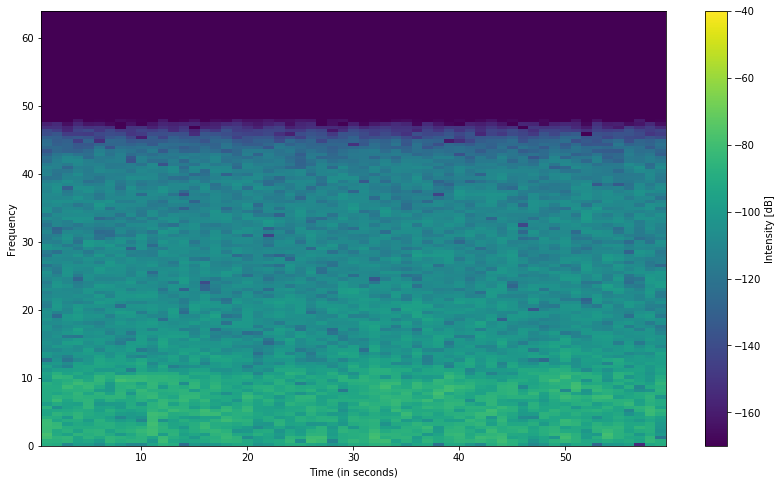

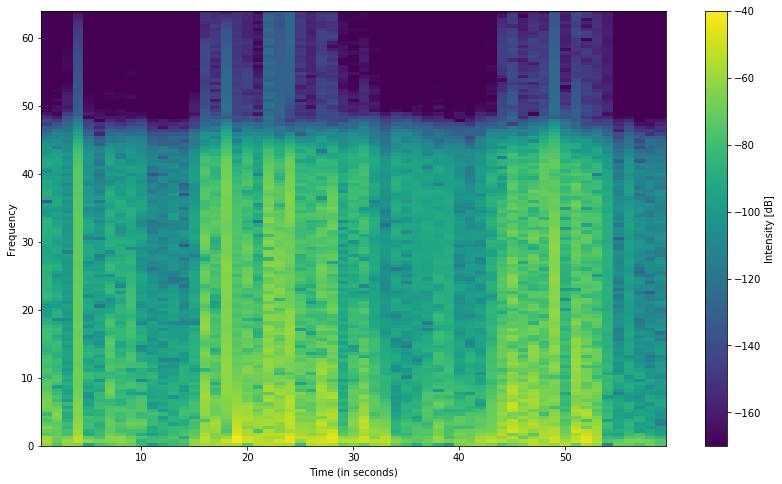

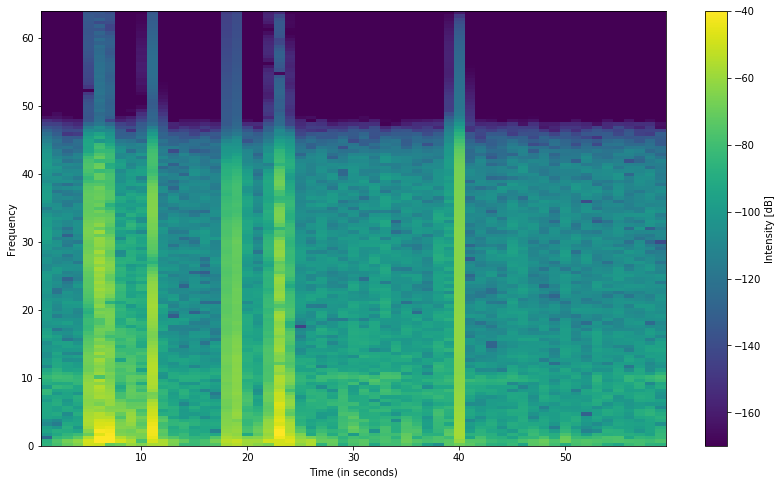

In [301]:
plot_specgram(data_log_test[i[0],:],title='', 
              x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))
savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/5_th_nearest_neighbor_outlier_score_bedst_score.png')

plot_specgram(data_log_test[i[1],:],title='', 
              x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))
savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/5_th_nearest_neighbor_outlier_score_next_bedst_score.png')

plot_specgram(data_log_test[i[-6],:],title='', 
              x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))
savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/5_th_nearest_neighbor_outlier_score_worst_score.png')

plot_specgram(data_log_test[i[-7],:],title='', 
              x_label='Time (in seconds)', y_label='Frequency', fig_size=(14,8))
savefig('/Users/ibenfjordkjaersgaard/Documents/GitHub/DeepLearningProject/5_th_nearest_neighbor_outlier_scorenext_worst_score.png')

